In [1]:
import pandas as pd
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [2]:
df = pd.read_parquet("day0_data_cleaned.parquet")

In [3]:

# set the X and Y
X = df.drop(['date_id', 'symbol_id', 'time_id', 'weight', 'responder_6'], axis=1)
y = df["responder_6"]

In [4]:
# set train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Create XGBoost Model
model = XGBRegressor(
    n_estimators=100,  
    learning_rate=0.1,  
    max_depth=6,  
    random_state=42,
    objective='reg:squarederror'  
)



In [8]:
# model training
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [9]:
# predict
y_pred = model.predict(X_test)

In [10]:
# model evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R² Score:", r2)

Mean Squared Error (MSE): 0.7097944021224976
Root Mean Squared Error (RMSE): 0.8424929685893512
Mean Absolute Error (MAE): 0.5491036176681519
R² Score: 0.06535732746124268


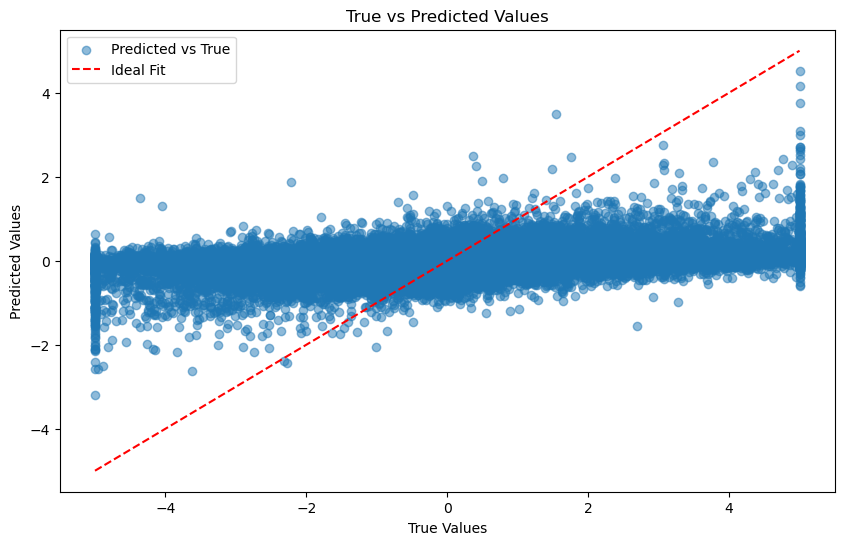

In [ ]:
# result visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predicted vs True")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label="Ideal Fit")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.legend()
plt.show()

We can see that the model predicts very badly, and we need to find if there's any better hyperparameter. 

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score

# identify parameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1],
    "colsample_bytree": [0.8, 1.0]
}

best_score = -float("inf")
best_params = None

# manual grid search(to shorten the time needed)
for params in ParameterGrid(param_grid):
    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = r2_score(y_test, y_pred)
    
    if score > best_score:
        best_score = score
        best_params = params

print("Best Parameters:", best_params)
print("Best R² Score:", best_score)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Best R² Score: 0.1807745099067688


In [5]:
# The best parameter model
model = XGBRegressor(
    n_estimators=300,  # number of trees
    learning_rate=0.1,  # learning rate 
    max_depth=7,  # max depth of tree
    random_state=42,
    colsample_bytree=1.0,
    objective='reg:squarederror'  
)

In [6]:
# training model
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)


In [7]:
import joblib


In [8]:
# preserve model into current folder(.pkl format)
joblib.dump(model, "model.pkl")

print("model preserved as model.pkl")

model preserved as model.pkl


In [ ]:
# model evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R² Score:", r2)

Mean Squared Error (MSE): 0.6221432685852051
Root Mean Squared Error (RMSE): 0.7887605901572448
Mean Absolute Error (MAE): 0.5254529714584351
R² Score: 0.1807745099067688


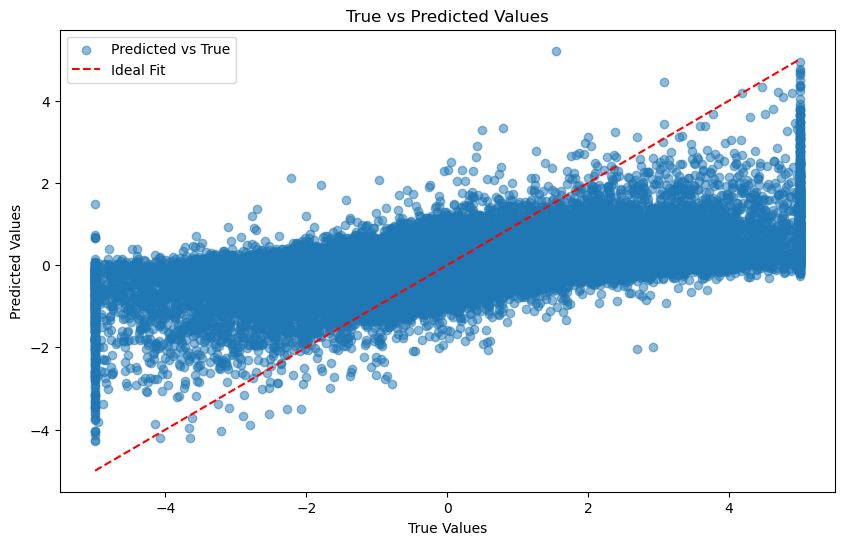

In [ ]:
# result visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predicted vs True")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label="Ideal Fit")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.legend()
plt.show()

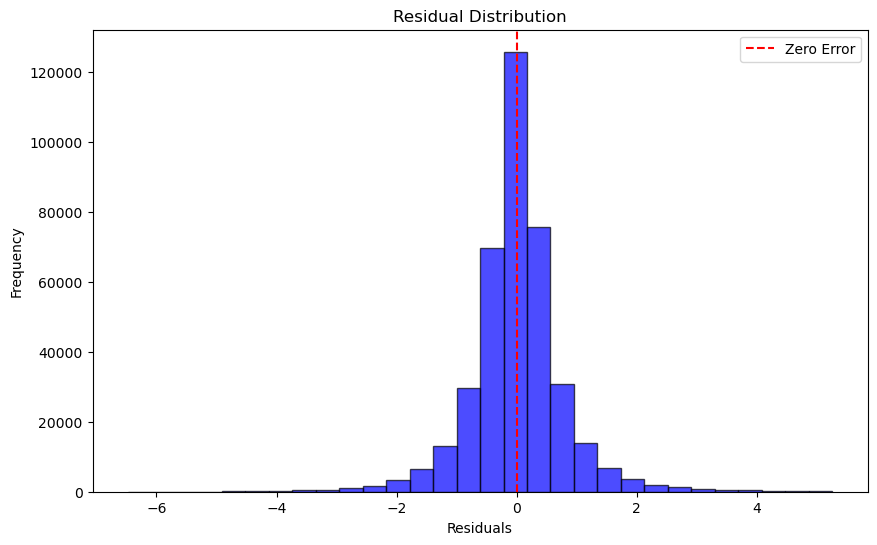

In [27]:
# 计算残差
residuals = y_test - y_pred

# 绘制残差分布图
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.legend()
plt.show()


Now we put id columns into considerration, trying to make time seires analysis. 

In [43]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

In [28]:
# read in data
data = pd.read_parquet("day0_data_cleaned.parquet")

In [29]:
# arrange in time order
data = data.sort_values(by=["date_id", "time_id", "symbol_id"])

In [30]:
# create Lag Features
def create_lag_features(df, lag_columns, lags=[1, 2, 3]):
    for col in lag_columns:
        for lag in lags:
            df[f"{col}_lag{lag}"] = df[col].shift(lag)
    return df

In [31]:
# select feature columns to create lags
feature_columns = [col for col in data.columns if col not in ['date_id', 'time_id', 'symbol_id', 'responder_6']]
data = create_lag_features(data, feature_columns, lags=[1, 2, 3])

C:\Users\16536\AppData\Local\Temp\ipykernel_46464\3324207611.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag{lag}"] = df[col].shift(lag)
C:\Users\16536\AppData\Local\Temp\ipykernel_46464\3324207611.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag{lag}"] = df[col].shift(lag)
C:\Users\16536\AppData\Local\Temp\ipykernel_46464\3324207611.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

In [32]:

# turn symbol_id into categorical variable
data['symbol_id'] = data['symbol_id'].astype("category").cat.codes  

In [33]:
# delete missing values caused by shift
data = data.dropna().reset_index(drop=True)

In [34]:
# split training set and test set by time order
train_size = int(len(data) * 0.8)  # first 80% as training set, last 20% as test set
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]


In [35]:

X_train, y_train = train_data.drop(columns=['responder_6']), train_data['responder_6']
X_test, y_test = test_data.drop(columns=['responder_6']), test_data['responder_6']

In [41]:
# XGBoost time series regression model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  
    eval_metric='rmse',
    learning_rate=0.1,
    n_estimators=300,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [45]:
# conduct time series cross validation(TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []

for train_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    xgb_model.fit(X_tr, y_tr)
    y_val_pred = xgb_model.predict(X_val)
    
    rmse = mean_squared_error(y_val, y_val_pred) ** 0.5
    rmse_scores.append(rmse)

print(f"cross validation RMSE mean: {np.mean(rmse_scores):.4f}, standard error: {np.std(rmse_scores):.4f}")


cross validation RMSE mean: 0.8458, standard error: 0.0633


In [46]:
# train the final model
xgb_model.fit(X_train, y_train)

# predict
y_pred = xgb_model.predict(X_test)


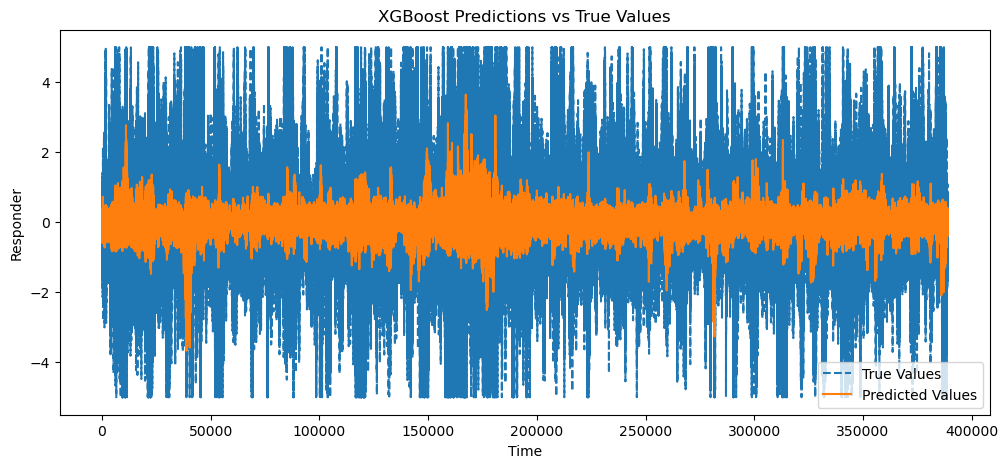

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# result visualization
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label="True Values", linestyle="dashed")
plt.plot(y_pred, label="Predicted Values")
plt.xlabel("Time")
plt.ylabel("Responder")
plt.legend()
plt.title("XGBoost Predictions vs True Values")
plt.show()


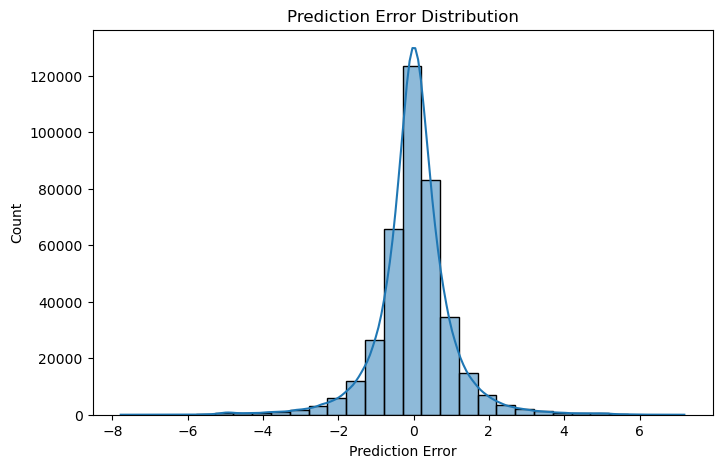

In [49]:
# error plot
errors = y_pred - y_test.values


plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=30, kde=True)
plt.xlabel("Prediction Error")
plt.title("Prediction Error Distribution")
plt.show()


In [47]:
# model evaluation
rmse_test = mean_squared_error(y_test, y_pred)** 0.5
r2_test = r2_score(y_test, y_pred)

print(f"test set RMSE: {rmse_test:.4f}")
print(f"test set R²: {r2_test:.4f}")

test set RMSE: 0.9994
test set R²: -0.0060


The result shows that with time lag columns, the model performs even worse. Next we will conduct SHAP analysis for model without time analysis. 

In [1]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [2]:
import shap
import matplotlib.pyplot as plt

c:\Users\16536\anaconda3\envs\seminar\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# SHAP values
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)


100%|===================| 388807/388842 [46:27<00:00]        

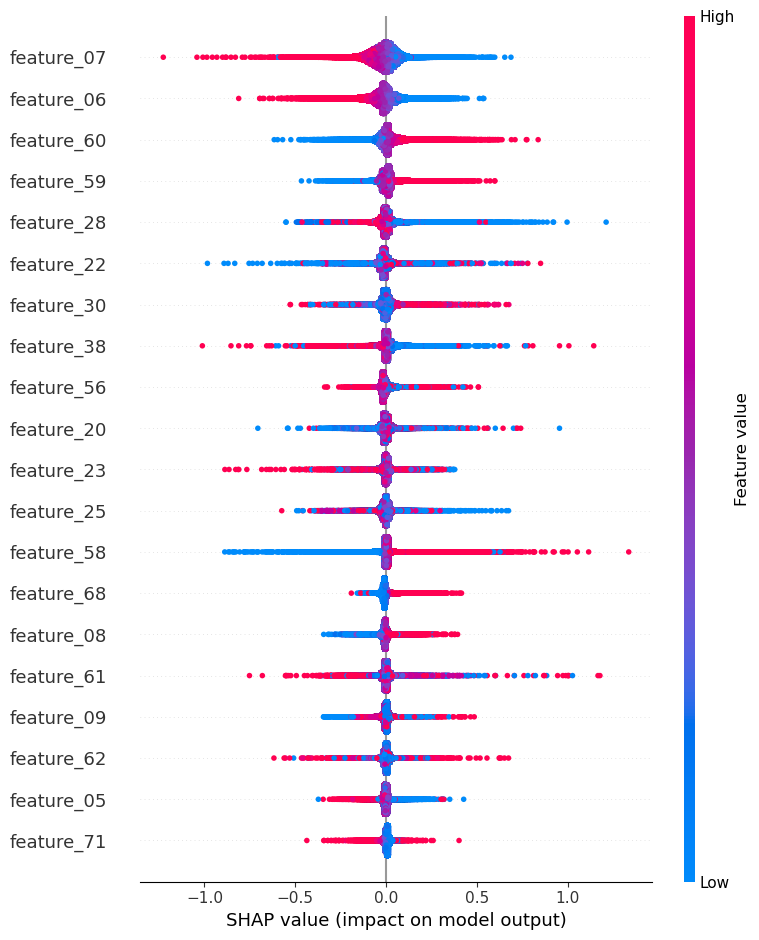

In [ ]:
# plot SHAP feature importance map
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test)